In [1]:
from HeaderP import *
from IPython.display import display, Math

# load cluster

In [2]:
M67 = pd.read_csv('m67_subset_wphot.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 3.8*np.ones(len(M67))
M67['Cluster'] = 'M67'
M67['M_G'] = m_to_M(M67['phot_g_mean_mag'], 0.85)
M67['Age_err'] = 0.1

oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Age_err'] = oc['AGE_err']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67])
oc['Prot_log'] = np.log10(oc['Prot'])
oc = oc.loc[oc['Age']>0.5]
#oc = oc.loc[oc['Age']>0.7]
oc = oc.loc[~(oc['Age']==1.4)]

uniqage = oc['Age'].unique()
print(uniqage)



oc = oc.loc[~((oc['teff_calc']<4000)&(oc['Prot']<10))]
oc = oc.loc[~((oc['teff_calc']<3500)&(oc['Prot']<15))]
oc = oc.loc[~((oc['Age']==2.7)&(oc['Prot']>20)&(oc['teff_calc']>5900))]
oc = oc.loc[~((oc['teff_calc']<3400)&(oc['Prot']<20))].reset_index(drop=True)

noage = 0
m = (oc['Age']==uniqage[noage])
print(uniqage[noage])

oc = oc.dropna(subset=['teff_calc','Prot'])

from scipy import interpolate
allms = np.zeros(len(oc), dtype=bool)
# sigma clipping clusters
for i in range(len(uniqage)):
    if uniqage[i]==3.8:
        m = (oc['Age']==uniqage[i])
        allms[m] = 1
        continue
    m = (oc['Age']==uniqage[i])
    teffrun, protrun, ind = zip(*(sorted(zip(oc['teff_calc'][m].values, oc['Prot'][m].values, oc['Prot'][m].index))))
    teffrun, protrun = np.array(teffrun), np.array(protrun)
    teffrun_mov, protrun_mov = movingMed_time(teffrun,protrun,10,200)
    teffrun_mov[teffrun_mov==0] = teffrun[teffrun_mov==0]
    protrun_mov[teffrun_mov==0] = protrun[teffrun_mov==0]
    
    f = interpolate.interp1d(teffrun_mov, protrun_mov, fill_value='extrapolate')
    if i==0:
        pcut = interpolate.interp1d(teffrun_mov, protrun_mov, fill_value='extrapolate')
        #plt.plot(teffrun_mov, protrun_mov, 'k-o')
    mcut = abs(oc['Prot'][m]-f(oc['teff_calc'][m]))<2
    allms[m] = mcut
    
    
oc = oc[allms].reset_index(drop=True)
print(len(oc))

oc.to_csv('oc_final.csv', index=False)

[0.67 0.73 1.   2.5  2.7  3.8 ]
0.67
661


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


## load ztf

In [3]:
teffcut = 4200
ztf = pd.read_csv('AllztfAge.csv')
ztf['abs_G_dered'] = ztf['abs_G']
ztf['kin_age'] = ztf['kin_age']+1
ztf = ztf.loc[(ztf['teff_calc']<=teffcut)|(ztf['Prot_log']>1.4)]
print(len(ztf))
#ztf = pd.read_pickle('AllztfAge_grp.pkl')
ztf_sub = pd.read_pickle('AllztfAge_grp_cor2.pkl')
#ztf_sub['kin_age'] = ztf_sub['kin_age_cor']
ztf_sub = ztf_sub.loc[(ztf_sub['teff_calc']>teffcut)&(ztf_sub['Prot_log']<1.4)]
ztf = pd.concat([ztf, ztf_sub])
print(len(ztf))

"""ztf = pd.read_pickle('AllztfAge_grp_cor.pkl')
ztf['kin_age'] = ztf['kin_age_cor']"""

ztf_kepler = ztf.dropna(subset=['KID'])
ztf = ztf.drop_duplicates('gaiaid', keep='first')
ztf = pd.concat([ztf, ztf_kepler])
print(len(ztf))

#ztf['kin_age'] = ztf['kin_age']-0.5
#ztf = ztf.loc[~((ztf['Prot_log']>1.7)&(ztf['kin_age']<5)&(ztf['teff_calc']>3000))]
ztf = ztf.loc[ztf['Prot_log']>np.log10(pcut(ztf['teff_calc']))]
ztf = ztf.loc[ztf['kin_age']>1.5]
ztf = ztf.loc[ztf['kin_age']<20]
ztf = ztf.loc[ztf['Prot_log']>0]
ztf = ztf.loc[~((ztf['kin_age']<2)&(ztf['teff_calc']<4000))]
ztf = ztf.loc[~((ztf['kin_age']<1.5)&(ztf['teff_calc']>4000))].reset_index(drop=True)
pcut_mag = fitpoints([1.7, 1.95], [2,10])
ztf = ztf.loc[~((ztf['abs_G_dered']<10.5)&(ztf['kin_age']<pcut_mag(ztf['Prot_log'])))].reset_index(drop=True)

len(ztf)
ztf = ztf.loc[ztf['abs_G_dered']>4.2]
ztf = ztf.drop_duplicates('gaiaid', keep='first')
ztf = ztf.loc[(ztf['kin_age']<14)&(ztf['Ro']<2)].reset_index(drop=True)

len(ztf)

50333
82136
102048


/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_89383/1348118677.py:24: RuntimeWarning: divide by zero encountered in log10
  ztf = ztf.loc[ztf['Prot_log']>np.log10(pcut(ztf['teff_calc']))]


46362

In [9]:
import jax
import numpy as np
import jax.numpy as jnp
from tinygp import kernels


import jaxopt
from tinygp import GaussianProcess, kernels, transforms
from functools import partial

def mean_function_both(params, X):
    # Prot broken low
    teffnorm = (7000.-X[0])/(7000.-params["teff_cut"])
    prot = jnp.power(10.,X[1])
    # Prot broken low
    stepfunc_low_prot = 1.0 / (1.0 + jnp.exp(-(jnp.log10(params['prot_cut']) - X[1]) / abs(params['w_prot'])))
    stepfunc_high_prot = 1.0 / (1.0 + jnp.exp(-(-jnp.log10(params['prot_cut']) + X[1]) / abs(params['w_prot'])))
    
    mod_high_prot = jnp.power(prot,params["b"])
    mod_high_prot = mod_high_prot*stepfunc_high_prot
    
    mod_low_prot = jnp.power(prot,params["b2"])*jnp.power(params["prot_cut"],params["b"]-params["b2"])
    mod_low_prot = mod_low_prot*stepfunc_low_prot
    
    prot_func = mod_high_prot+mod_low_prot
    
    # teff broken low
    stepfunc_high_teff = 1.0 / (1.0 + jnp.exp(-(1. - teffnorm) / abs(params['w_teff'])))
    stepfunc_low_teff = 1.0 / (1.0 + jnp.exp(-(-1. + teffnorm) / abs(params['w_teff'])))
    
    
    mod_high_teff = jnp.power(teffnorm-params["c"],params["d"])
    mod_high_teff = mod_high_teff*stepfunc_high_teff
    
    mod_low_teff = jnp.power(teffnorm-params["c"],params["d2"])*jnp.power(1.-params["c"],params["d"]-params["d2"])
    mod_low_teff = mod_low_teff*stepfunc_low_teff
    teff_func = mod_high_teff+mod_low_teff
    
    return params["a"]*prot_func*teff_func


def build_gp(params, X, yerr):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.array([jnp.exp(-params["log_scale1"]), jnp.exp(-params["log_scale2"])]),
        kernels.ExpSquared()
    )

    return GaussianProcess(
        kernel, X, diag=yerr**2,mean=partial(mean_function_both, params)
    )






In [10]:
val

NameError: name 'val' is not defined

In [ ]:
mean_function_both(val)

## FC

In [5]:
def mean_function_both_FC(params, X):
    # Prot broken low
    # Prot broken low
    teffnorm = (3500.-X[0])/500.
    prot = jnp.power(10.,X[1])
    # Prot broken low
    stepfunc_low_prot = 1.0 / (1.0 + jnp.exp(-(jnp.log10(params['prot_cut']) - X[1]) / abs(params['w_prot'])))
    stepfunc_high_prot = 1.0 / (1.0 + jnp.exp(-(-jnp.log10(params['prot_cut']) + X[1]) / abs(params['w_prot'])))
    
    mod_high_prot = jnp.power(prot,params["b"])
    mod_high_prot = mod_high_prot*stepfunc_high_prot
    
    mod_low_prot = jnp.power(prot,params["b2"])*jnp.power(params["prot_cut"],params["b"]-params["b2"])
    mod_low_prot = mod_low_prot*stepfunc_low_prot
    
    prot_func = mod_high_prot+mod_low_prot
    
    # teff broken low
    mod_high_teff = jnp.power(teffnorm-params["c"],params["d"])
    teff_func = mod_high_teff
    
    return params["a"]*prot_func*teff_func


def build_gp_FC(params, X, yerr):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.array([jnp.exp(-params["log_scale1"]), jnp.exp(-params["log_scale2"])]),
        kernels.ExpSquared()
    )

    return GaussianProcess(
        kernel, X, diag=yerr**2,mean=partial(mean_function_both_FC, params)
    )

# Corner plot

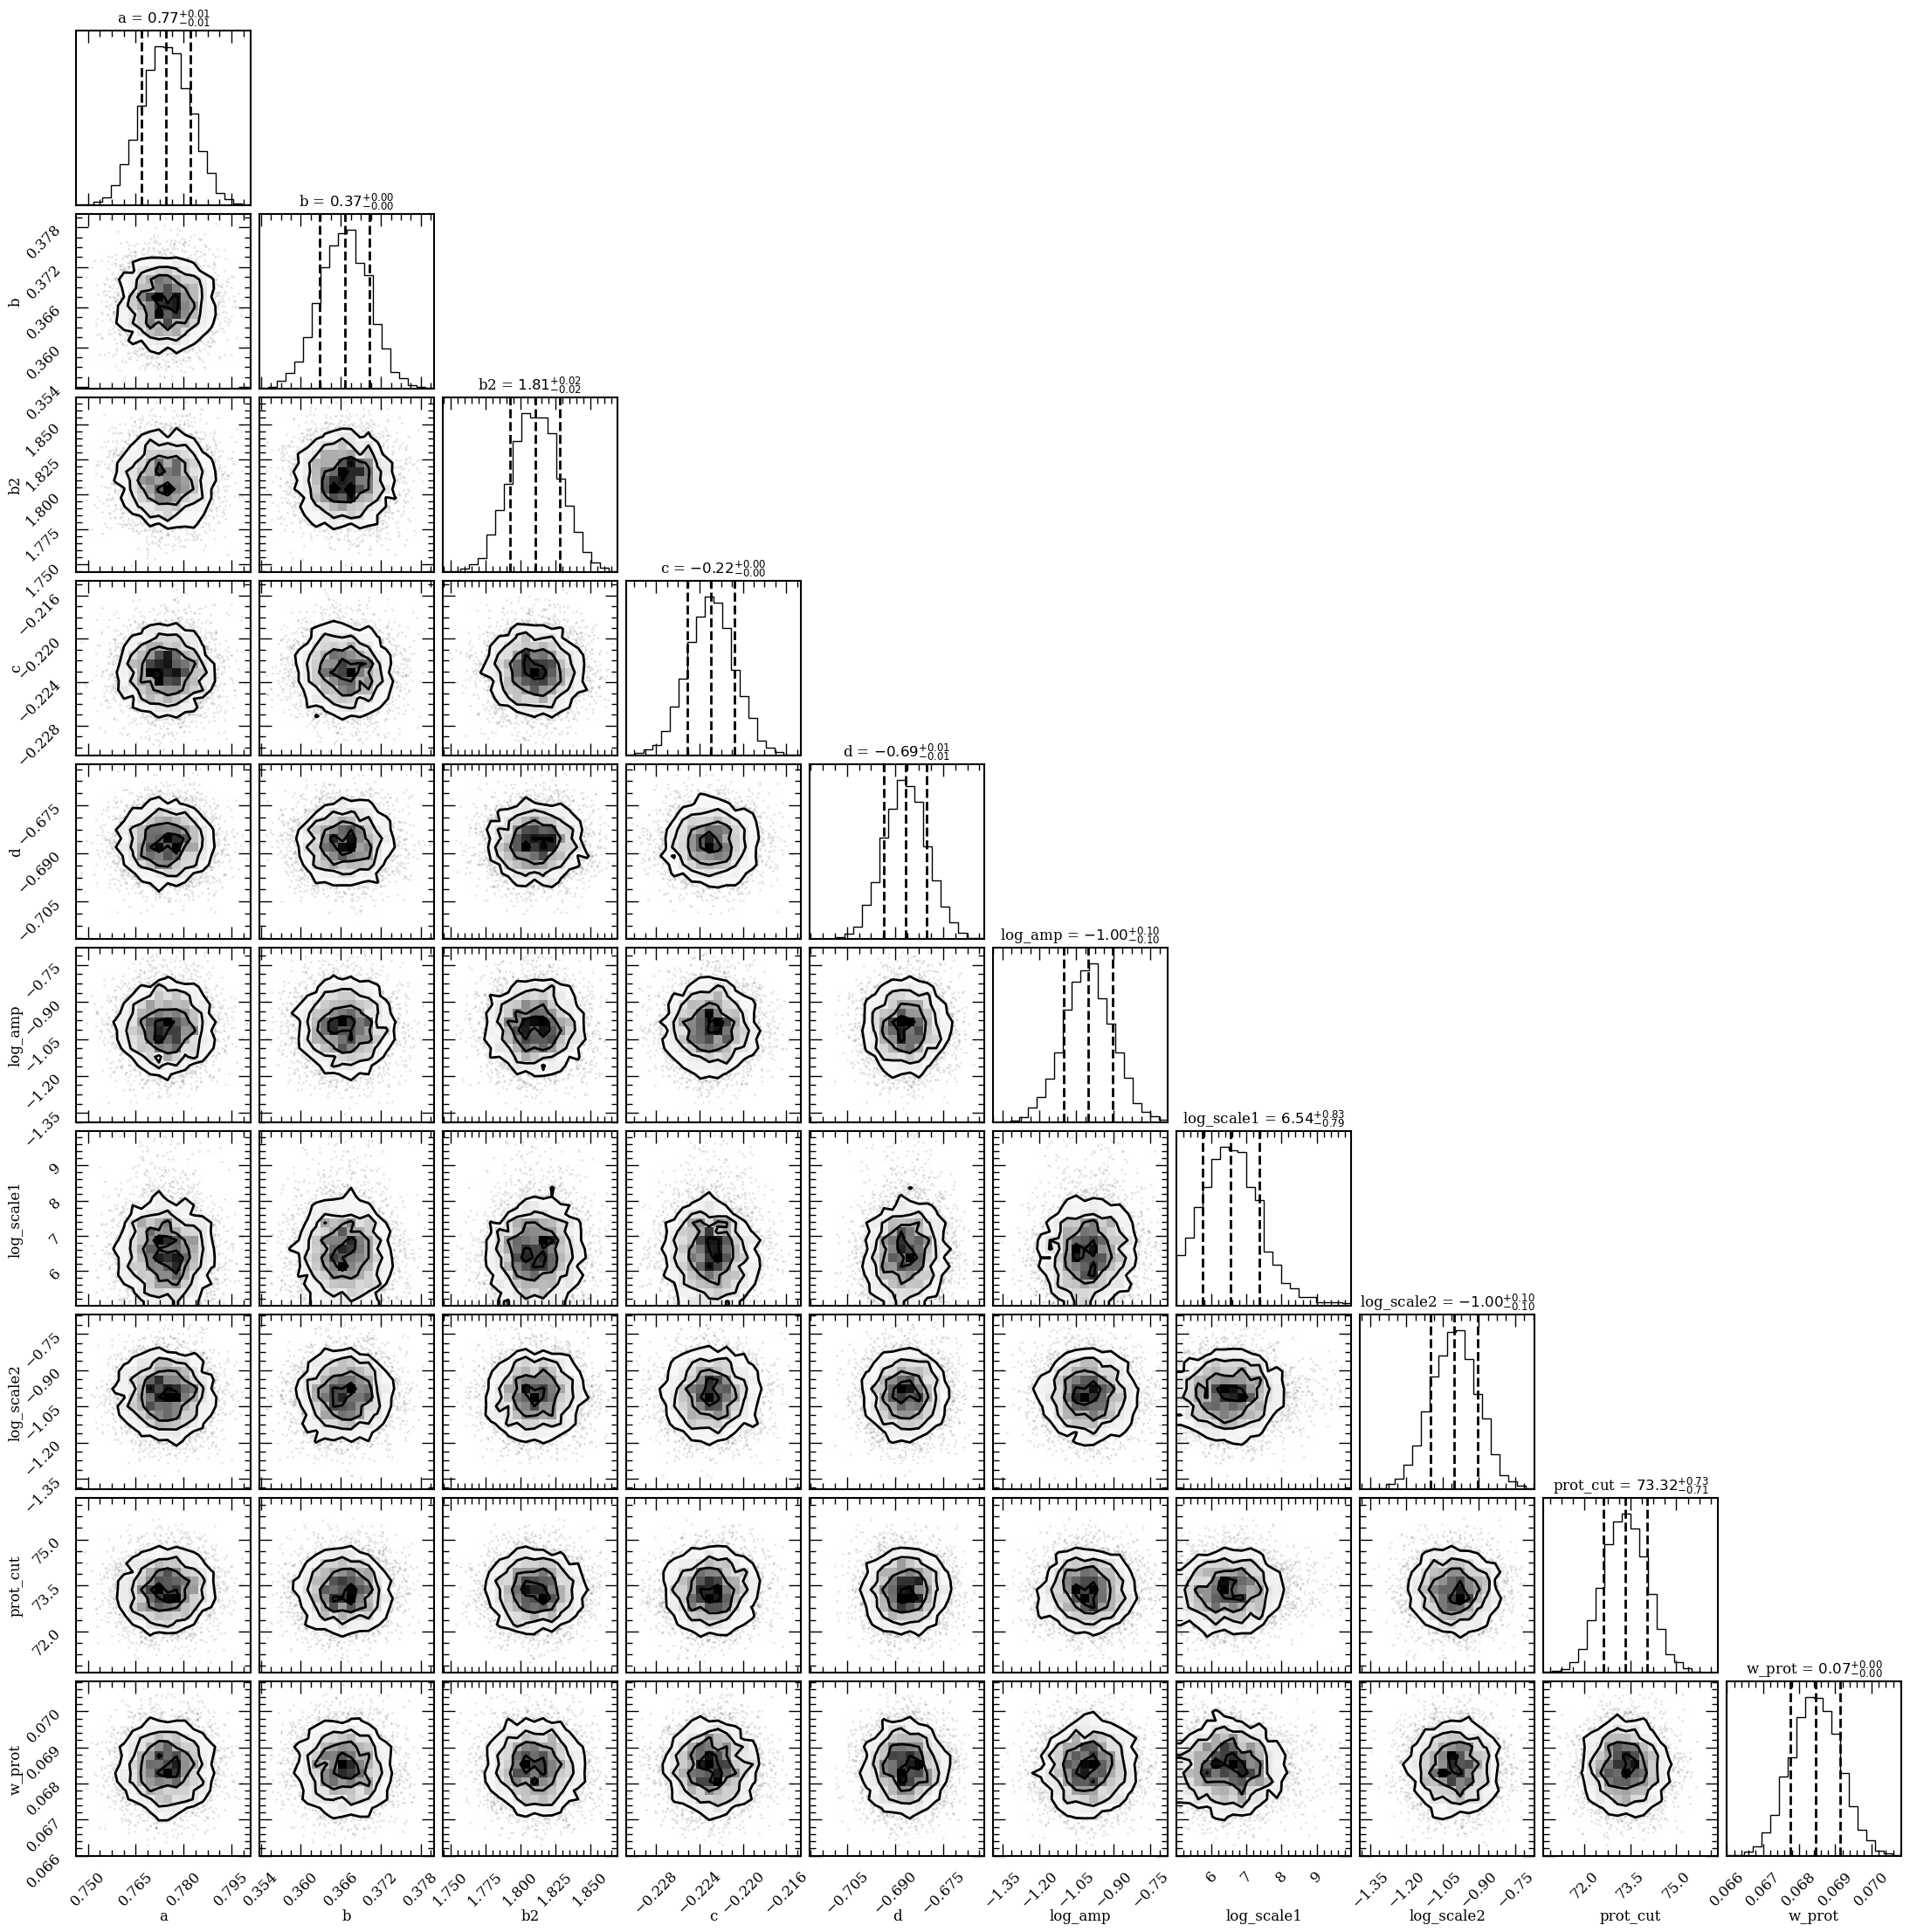

In [6]:
allkeys = ['a', 'b', 'b2', 'c', 'd', 'd2', 'log_amp', 'log_scale1',
           'log_scale2', 'prot_cut', 'teff_cut', 'w_prot', 'w_teff']
sample_PC = np.load('sample_PC.npy')

allkeys_fc = ['a', 'b', 'b2', 'c', 'd', 'log_amp', 'log_scale1',
           'log_scale2', 'prot_cut', 'w_prot']
sample_FC = np.load('sample_FC.npy')

sample_pc_fig = np.zeros(np.shape(sample_FC))
sample_pc_fig[0:5,:] = sample_PC[0:5,:]
sample_pc_fig[5:9,:] = sample_PC[6:10,:]
sample_pc_fig[9,:] = sample_PC[11,:]

plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   }
plt.rcParams.update(params)

import arviz as az
import corner

figure = corner.corner(sample_PC.T, quantiles=[0.16, 0.5, 0.84],
    show_titles=True,labels=allkeys,
    title_kwargs={"fontsize": 12},
              label_kwargs={"fontsize": 12});
plt.xticks(fontsize=12)
plt.savefig('Corner.png')


m = ((sample_FC[6,:]>5)&(sample_FC[6,:]<10))
sample_FC = sample_FC[:,m]
figure2 = corner.corner(sample_FC.T, quantiles=[0.16, 0.5, 0.84],
    show_titles=True,labels=allkeys_fc,
    title_kwargs={"fontsize": 12},
              label_kwargs={"fontsize": 12},
                       color='k');
"""corner.corner(sample_pc_fig.T, quantiles=[0.16, 0.5, 0.84],
    show_titles=True,labels=allkeys_fc,
    title_kwargs={"fontsize": 12},
              label_kwargs={"fontsize": 12},
                       color='k',
             fig=figure2);"""

plt.xticks(fontsize=12)
plt.savefig('Corner_FC.png')


# PC stars

In [7]:
finalval = []
finalval_m = []
finalval_p = []

for i in range(np.shape(sample_PC.T)[1]):
    mcmc = np.percentile((sample_PC.T)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], allkeys[i])
    display(Math(txt))
    finalval.append(mcmc[1])
    finalval_m.append(q[0])
    finalval_p.append(q[1])
    
sample_PC = pd.DataFrame(sample_PC.T, columns=allkeys)
sample_PC = sample_PC.sample(n=100)

def GP_gyro_PC(X, sample):
    X_t = np.load('X.npy')
    y_t = np.load('yerr.npy')
    y = np.load('y.npy')
    allkeys = ['a', 'b', 'b2', 'c', 'd', 'd2', 'log_amp', 'log_scale1',
           'log_scale2', 'prot_cut', 'teff_cut', 'w_prot', 'w_teff']
    outputage = np.zeros((len(sample),len(X)))
    for i in trange(len(sample)):
        val = sample.iloc[i][allkeys]
        uncorr_gp = build_gp(val, np.load('X.npy'), np.load('yerr.npy'))
        outputage[i,:] = uncorr_gp.condition(y, X).gp.loc.reshape(len(X))
        
    ages = np.zeros(len(X))
    ages_p = np.zeros(len(X))
    ages_m = np.zeros(len(X))
    for i in range(len(X)):
        mcmc = np.percentile((outputage)[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        ages[i] = mcmc[1]
        ages_m[i] = -q[0]
        ages_p[i] = q[1]
    return ages, ages_m, ages_p


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# FC stars

In [8]:
sample_FC = np.load('sample_FC.npy')

finalval = []
finalval_m = []
finalval_p = []

for i in range(np.shape(sample_FC.T)[1]):
    mcmc = np.percentile((sample_FC.T)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], allkeys_fc[i])
    display(Math(txt))
    finalval.append(mcmc[1])
    finalval_m.append(q[0])
    finalval_p.append(q[1])
    
sample_FC = pd.DataFrame(sample_FC.T, columns=allkeys_fc)
sample_FC = sample_FC.sample(n=100)

def GP_gyro_FC(X, sample):
    X_t = np.load('X_fc.npy')
    y_t = np.load('yerr_fc.npy')
    y = np.load('y_fc.npy')
    allkeys = ['a', 'b', 'b2', 'c', 'd', 'log_amp', 'log_scale1',
           'log_scale2', 'prot_cut', 'w_prot']
    outputage = np.zeros((len(sample),len(X)))
    for i in trange(len(sample)):
        val = sample.iloc[i][allkeys]
        uncorr_gp = build_gp_FC(val, np.load('X_fc.npy'), np.load('yerr_fc.npy'))
        outputage[i,:] = uncorr_gp.condition(y, X).gp.loc.reshape(len(X))
        print(outputage[i,:])
    ages = np.zeros(len(X))
    ages_p = np.zeros(len(X))
    ages_m = np.zeros(len(X))
    for i in range(len(X)):
        mcmc = np.percentile((outputage)[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        ages[i] = mcmc[1]
        ages_m[i] = -q[0]
        ages_p[i] = q[1]
    return ages, ages_m, ages_p



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Master function to get ages 

In [9]:
def GP_gyro(X, MG, sample_FC, sample_PC):
    jaogap = fitpoints([3560/2+3526.5/2, 3427.36/2+3395.1/2], [10.09, 10.24])
    m_pc = MG<jaogap(X[:,0])
    ages_all = np.zeros(len(X))
    ages_p_all = np.zeros(len(X))
    ages_m_all = np.zeros(len(X))
    
    ages_all[m_pc], ages_p_all[m_pc], ages_m_all[m_pc] = GP_gyro_PC(X[m_pc,:], sample_PC)
    ages_all[~m_pc], ages_p_all[~m_pc], ages_m_all[~m_pc] = GP_gyro_FC(X[~m_pc,:], sample_FC)
    return ages_all, ages_m_all, ages_p_all


# Get ages for AS stars

In [10]:
from astropy.io import ascii
legacy = pd.read_csv('GP_pred_LEGACY.csv')
X_aster = legacy[['teff_calc','Prot_log']].values
legacy['gyroage'], legacy['gyroage_m'], legacy['gyroage_p'] = GP_gyro_PC(X_aster, sample_PC)

fehlegacy = ascii.read('legacy_feh.txt').to_pandas()
legacy = pd.merge(legacy, fehlegacy[['KIC','[Fe/H]']], 
                 left_on='KIC_x', right_on='KIC',
                 how='left')


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


In [24]:
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   'text.usetex': False,
   }
plt.rcParams.update(params)

def LouisTurnoverTime(Teff):
    if (Teff<=3480.):
        tauLouis = 10.**(6.52112823e-7*Teff**2. - 4.00355099e-3*Teff + 8.68234621)
    else:
        tauLouis = 10.**(-2.51904051e-10*Teff**3. + 3.73613409e-6*Teff**2. - 1.85566042e-2*Teff + 32.5950535)
    #renormalise to CS11 scale
    tau = tauLouis*13.79/35.54
 
    return tau


    
legacy['τc'] = [LouisTurnoverTime(i) for i in legacy['teff_calc']]
legacy['Ro'] = legacy['Prot']/legacy['τc']

kids = legacy['KIC_x'].unique()

age_pred = []
age_leg = []

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
#plt.plot(legacy['gyroage'],legacy['Age'],'ko')
lagend=[0,0]
for i in range(len(kids)):
    kepler_sing = legacy.loc[legacy['KIC_x']==kids[i]]
    
    age_std = np.std(kepler_sing['Age'])
    age_mean = np.mean(kepler_sing['Age'])
    
    plt.hlines(kepler_sing['gyroage'].values[0], 
               age_mean-age_std, age_mean+age_std,
              color='k',zorder=5)
    
    plt.vlines(age_mean, 
               (kepler_sing['gyroage']+kepler_sing['gyroage_m']).values[0], 
               (kepler_sing['gyroage']+kepler_sing['gyroage_p']).values[0], 
              color='k',zorder=5)
    
    age_pred.append(kepler_sing['gyroage'].values[0])
    age_leg.append(np.mean(kepler_sing['Age']))
    
    if kepler_sing['abs_G_dered'].values[0] < 4.2:
        if lagend[0]==0:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                    c=kepler_sing['teff_calc'].values[0],s=200,edgecolor='k',marker='x',
                        linewidth=5,zorder=7,vmin=5000, vmax=6500,
                        cmap=plt.get_cmap('viridis',10),
                       label='$M_G$ < 4.2')
            lagend[0]=1
        else:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                c=kepler_sing['teff_calc'].values[0],s=200,edgecolor='k',marker='x',
                    linewidth=5,zorder=7,vmin=5000, vmax=6500,
                    cmap=plt.get_cmap('viridis',10))
    else:
        if lagend[1]==0:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                c=kepler_sing['teff_calc'].values[0],s=200,edgecolor='k',
               zorder=10,cmap=plt.get_cmap('viridis',10),vmin=5000, vmax=6500,
                   label='$M_G\geq$ 4.2')
            lagend[1]=1
        else:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                c=kepler_sing['teff_calc'].values[0],s=200,edgecolor='k',
               zorder=10,cmap=plt.get_cmap('viridis',10),vmin=5000, vmax=6500)

plt.plot([0,14],[0,14], 'r-')
#plt.plot([0,14],[1,15], 'r--')
#plt.plot([0,14],[-1,13], 'r--')
plt.xlim([0.2,14])
plt.ylim([0.2,14])
plt.ylabel('GP Gyrochronology Age [Gyr]')
plt.xlabel('LEGACY Age [Gyr]')
plt.colorbar(label='$Ro$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best', bbox_to_anchor=(0.005, 0.3, 0.45, 0.5))

diffs = []
diffs_err = []
fehs = []
teffsall = []
logg = []
asages = []
ros = []
plt.subplot(1,2,2)
"""plt.scatter(legacy['gyroage'],legacy['Age'],c=legacy['abs_G_dered'],
           vmin=4.2)"""
for i in range(len(kids)):
    kepler_sing = legacy.loc[legacy['KIC_x']==kids[i]]
    
    age_std = np.std(kepler_sing['Age'])
    age_mean = np.mean(kepler_sing['Age'])
    
    plt.hlines(kepler_sing['gyroage'].values[0], 
               age_mean-age_std, age_mean+age_std,
              color='k',zorder=5)
    
    plt.vlines(age_mean, 
               (kepler_sing['gyroage']+kepler_sing['gyroage_m']).values[0], 
               (kepler_sing['gyroage']+kepler_sing['gyroage_p']).values[0], 
              color='k',zorder=5)
    
    if kepler_sing['abs_G_dered'].values[0] < 4.2:
        if i==0:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                    c=kepler_sing['[Fe/H]'].values[0],s=200,edgecolor='k',
                        marker = 'x',linewidth=5,zorder=7,
                   vmin=-0.4, vmax=0.2, cmap=plt.get_cmap('viridis',10))
        else:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                    c=kepler_sing['[Fe/H]'].values[0],s=200,edgecolor='k',
                        marker = 'x',linewidth=5,zorder=7,
                   vmin=-0.4, vmax=0.2, cmap=plt.get_cmap('viridis',10))
    else:
        if i<10:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                    c=kepler_sing['[Fe/H]'].values[0],s=200,edgecolor='k',
                   vmin=-0.4, vmax=0.2, zorder=10,cmap=plt.get_cmap('viridis',10))
        else:
            plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0], 
                    c=kepler_sing['[Fe/H]'].values[0],s=200,edgecolor='k',
                   vmin=-0.4, vmax=0.2, zorder=10,cmap=plt.get_cmap('viridis',10))
    asages.append(np.mean(kepler_sing['Age']))
    diffs.append(np.mean(kepler_sing['Age'])-kepler_sing['gyroage'].values[0])
    diffs_err.append(np.std(kepler_sing['Age'])**2+(kepler_sing['gyroage_p'].values[0])**2)
    fehs.append(kepler_sing['[Fe/H]'].values[0])
    teffsall.append(kepler_sing['teff_calc'].values[0])
    logg.append(kepler_sing['logg'].values[0])
    ros.append(kepler_sing['Ro'].values[0])
    
diffs, fehs, teffsall, diffs_err = np.array(diffs), np.array(fehs), np.array(teffsall), np.array(diffs_err)
logg = np.array([i for i in logg])
plt.plot([0,14],[0,14], 'r-')
plt.xlim([0.2,14])
plt.ylim([0.2,14])
#plt.plot([1.5,1.5],[0,14])
#plt.plot([1.5,1.5],[0,14])
plt.ylabel('GP Gyrochronology Age [Gyr]')
plt.xlabel('LEGACY Age [Gyr]')
plt.colorbar(label='[Fe/H] [dex]')
plt.yscale('log')
plt.xscale('log')

age_pred, age_leg = np.array(age_pred), np.array(age_leg)
print(np.mean(age_pred-age_leg),
     np.var((age_pred-age_leg)))

m2 = (age_pred>1.5)
print(np.mean(age_pred[m2]-age_leg[m2]),
     np.mean(np.sqrt((age_pred[m2]-age_leg[m2])**2)))
plt.tight_layout()
plt.text(0.21, 4, 'Bias = %.2f Gyr\nMAD = %.2f Gyr'%(np.mean(age_pred-age_leg),
     np.median(abs(age_pred-age_leg))), fontsize=20)


plt.savefig('Kin_age_fig/fig8.png', bbox_inches='tight')




/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_52445/2464879707.py:82: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0],
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_52445/2464879707.py:89: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(kepler_sing['Age']),kepler_sing['gyroage'].values[0],
/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_52445/2464879707.py:144: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(kepler_si

-0.0881870141989266 4.413100618523947
0.08098075452996772 1.708332724380493


In [38]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
asages = np.array(asages)
"""plt.errorbar(fehs, abs(diffs)/asages, 
              yerr=np.sqrt((diffs_err/asages)**2+(diffs/asages**2*diffs_err)**2),
           markersize=1, fmt='ko', zorder=1)
plt.scatter(fehs, abs(diffs)/asages, 
              c=logg,
           s=100, edgecolor='k', zorder=2)"""

plt.errorbar(fehs, abs(diffs), 
              yerr=diffs_err,
           markersize=1, fmt='ko', zorder=1)
plt.scatter(fehs, abs(diffs), 
              c=logg,
           s=100, edgecolor='k', zorder=2)

zfeh = np.polyfit(fehs, abs(diffs), 3, w=1/diffs_err**2)
pfeh = np.poly1d(zfeh)
"""plt.plot(np.linspace(-1,0.5,100), pfeh(np.linspace(-1,0.5,100)),
        'r-')"""
plt.hlines(0,-1,0.5,color='r',linestyle='--')

import scipy
print(scipy.stats.pearsonr(fehs, abs(diffs)))
plt.xlabel('[Fe/H] [dex]')
#plt.ylabel('$Δτ/τ_{\\rm LEGACY}$')
plt.ylabel('$|τ_{\\rm LEGACY}-τ_{\\rm gyro}|$ [Gyr]')
#plt.yscale('log')
plt.colorbar(label='log($g$)')
plt.ylim([-1,10])

plt.subplot(1,2,2)
asages = np.array(asages)
"""plt.errorbar(fehs, abs(diffs)/asages, 
              yerr=np.sqrt((diffs_err/asages)**2+(diffs/asages**2*diffs_err)**2),
           markersize=1, fmt='ko', zorder=1)
plt.scatter(fehs, abs(diffs)/asages, 
              c=logg,
           s=100, edgecolor='k', zorder=2)"""

plt.errorbar(ros, abs(diffs), 
              yerr=diffs_err,
           markersize=1, fmt='ko', zorder=1)
plt.scatter(ros, abs(diffs), 
              c=teffsall,
           s=100, edgecolor='k', zorder=2,vmin=5000, vmax=6500)

zfeh = np.polyfit(fehs, abs(diffs), 3, w=1/diffs_err**2)
pfeh = np.poly1d(zfeh)
"""plt.plot(np.linspace(-1,0.5,100), pfeh(np.linspace(-1,0.5,100)),
        'r-')"""
plt.hlines(0,-1,11,color='r',linestyle='--')

import scipy
print(scipy.stats.pearsonr(fehs, abs(diffs)))
plt.xlabel('$Ro$')
#plt.ylabel('$Δτ/τ_{\\rm LEGACY}$')
plt.ylabel('$|τ_{\\rm LEGACY}-τ_{\\rm gyro}|$ [Gyr]')
#plt.yscale('log')
plt.colorbar(label='$T_{\\rm eff}$ [K]')
plt.ylim([-1,10])
plt.vlines(1.866,-1,10,color='blue',
           label='$Ro_{\\rm crit}$ (Saunders+ 2023)',
          zorder=10,linewidth=3)
plt.legend(fontsize=21)
plt.xscale('log')
plt.xlim([1,11])
plt.savefig('Kin_age_fig/feherr.png', bbox_inches='tight')
np.std(diffs)
plt.tight_layout()

PearsonRResult(statistic=-0.16055495083338467, pvalue=0.2603829107085973)
PearsonRResult(statistic=-0.16055495083338467, pvalue=0.2603829107085973)


In [35]:
import inspect
code, line_no = inspect.getsourcelines(fitpoints)
print(''.join(code))

def fitpoints(x,y,order=1):
    z = np.polyfit(x,y,order)
    p = np.poly1d(z)
    return p



# Predict individual cluster

## PC

In [146]:
X_t = np.load('X.npy')
y_t = np.load('yerr.npy')
y = np.load('y.npy')

X_pred = np.load('X_pred.npy')
y_true = np.load('y_true.npy')
m_y = np.load('m_y.npy')

sample = sample_PC

allkeys = ['a', 'b', 'b2', 'c', 'd', 'd2', 'log_amp', 'log_scale1',
           'log_scale2', 'prot_cut', 'teff_cut', 'w_prot', 'w_teff']


"""outputage = np.zeros((len(sample), np.shape(y_true)[0], np.shape(y_true)[1]))
for i in trange(len(sample_FC)):
    val = sample.iloc[i][allkeys]
    uncorr_gp = build_gp(val, np.load('X.npy'), np.load('yerr.npy'))
    cond_gp = uncorr_gp.condition(y, X_pred).gp
    outputage[i,:,:] = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)
"""
        

"outputage = np.zeros((len(sample), np.shape(y_true)[0], np.shape(y_true)[1]))\nfor i in trange(len(sample_FC)):\n    val = sample.iloc[i][allkeys]\n    uncorr_gp = build_gp(val, np.load('X.npy'), np.load('yerr.npy'))\n    cond_gp = uncorr_gp.condition(y, X_pred).gp\n    outputage[i,:,:] = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)\n"

In [147]:
np.shape(X_pred), np.shape(y_true), np.shape(X_t), np.shape(y_t)

((10000, 2), (100, 100), (1183, 2), (1183,))

In [148]:
#np.save('outputage', outputage)
outputage = np.load('outputage.npy')

In [149]:
y_pred = np.zeros(np.shape(y_true))
y_pred_err = np.zeros(np.shape(y_true))
for i in range(np.shape(y_pred)[0]):
    for j in range(np.shape(y_pred)[1]):
        mcmc = np.percentile((outputage)[:, i, j], [16, 50, 84])
        q = np.diff(mcmc)
        y_pred[i, j] = mcmc[1]
        y_pred_err[i, j] = np.std(outputage[:, i, j])
        

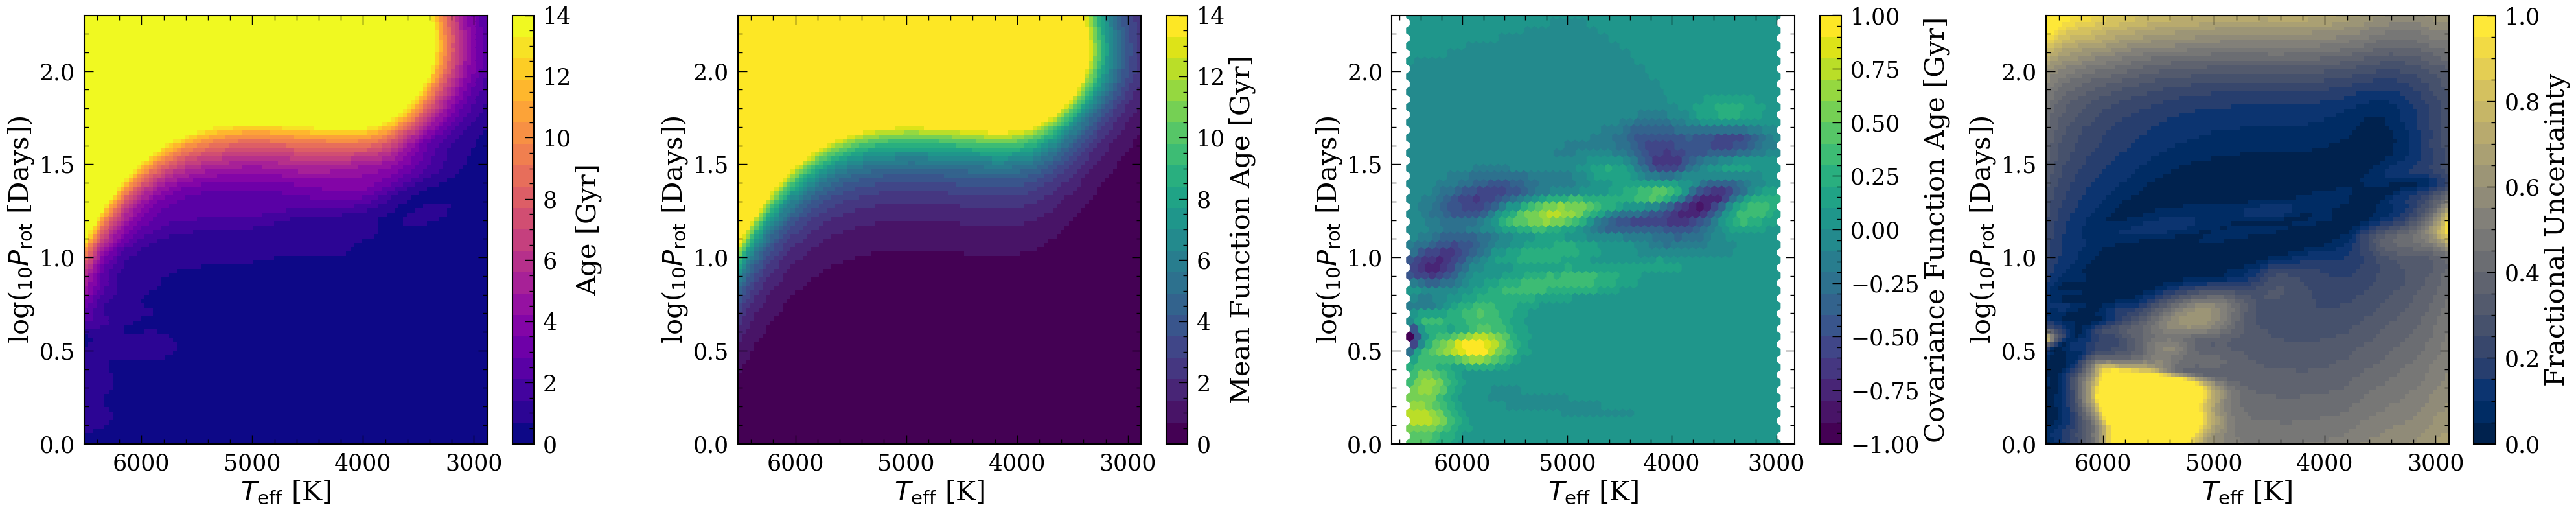

In [151]:

teffgrid = np.linspace(min(X_pred[:,0]), max(X_pred[:,0]), 70)
protgrid = np.linspace(min(X_pred[:,1]), max(X_pred[:,1]), 40)

x_grid, y_grid = np.linspace(min(teffgrid), max(teffgrid),100),  np.linspace(min(protgrid), max(protgrid), 100)
x_, y_ = np.meshgrid(x_grid, y_grid)

mean = np.load('mean_PC.npy')
mu = np.load('cov_PC.npy')

plt.figure(figsize=(40,8))

plt.subplot(1,4,1)
plt.pcolor(x_, y_, y_pred, vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Age [Gyr]')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')


plt.subplot(1,4,2)
plt.pcolor(x_, y_, mean, 
           vmin=0, vmax=14,
          cmap=plt.get_cmap('viridis',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Mean Function Age [Gyr]')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')


plt.subplot(1,4,3)
plt.hexbin(X_pred[:,0], X_pred[:,1], C=mu, vmin=-1, vmax=1,
          cmap=plt.get_cmap('viridis',20), 
           extent=(3000,6500,min(protgrid), max(protgrid)),
          gridsize=50)
plt.gca().invert_xaxis()
plt.colorbar(label='Covariance Function Age [Gyr]')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')


plt.subplot(1,4,4)
plt.pcolor(x_, y_, y_pred_err/y_pred, vmin=0, vmax=1,
          cmap=plt.get_cmap('cividis',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Fractional Uncertainty')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')

plt.tight_layout()

plt.savefig('Kin_age_fig/Final_PC_model.png')


In [183]:
LouisTurnoverTime(3000)*0.01

1.3475828947032202

In [138]:
jaogap = fitpoints([3560/2+3526.5/2, 3427.36/2+3395.1/2], [10.09, 10.24])
randomage = np.linspace(0.7, 10, 7)
plt.figure(figsize=(16,8))
plt.subplot(1,2,2)
ztf_pc = ztf.loc[ztf['abs_G_dered']<jaogap(ztf['teff_calc'])]
plt.hexbin(ztf_pc['teff_calc'], ztf_pc['Prot_log'], C=ztf_pc['kin_age'],
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10, alpha=0.5)

colors = getcolor(sorted(np.append([0,10],randomage)))

teffbins = np.linspace(3500, 7000, 20)

for i in range(len(randomage)):
    teff_plot, logprot_plot = [], []
    ageplot = randomage[i]
    for j in range(len(x_grid)):
        for ii in range(len(outputage[:,0,0])):  
            if min(abs(outputage[ii,:,j]-ageplot))/ageplot<0.05:
                teff_plot.append(x_grid[j])
                logprot_plot.append(y_grid[np.argmin(abs(outputage[ii,:,j]-ageplot))])
                
    teff_plot, logprot_plot = zip(*sorted(zip(teff_plot, logprot_plot))) 
    teff_plot, logprot_plot = np.array(teff_plot), np.array(logprot_plot)
    
    
    teff_plot_mm, logprot_plot_mm = np.zeros(len(teffbins)-1), np.zeros(len(teffbins)-1)
    logprot_plot_mm_err = np.zeros(len(teffbins)-1)
    for k in range(len(teffbins)-1):
        m = ((teff_plot>teffbins[k])&(teff_plot<teffbins[k+1]))
        logprot_plot_mm[k] = np.median(logprot_plot[m])
        logprot_plot_mm_err[k] = np.std(logprot_plot[m])
    
    
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color='w', linewidth=4)
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color=colors[i+1], linewidth=3)
    
    plt.fill_between(teffbins[1:]/2+teffbins[:-1]/2, 
                     logprot_plot_mm-logprot_plot_mm_err,
                     logprot_plot_mm+logprot_plot_mm_err, 
                     color=colors[i+1], alpha=0.5)

    
    
plt.scatter(-1000,-1000, c=0,
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10)

plt.ylim([min(protgrid), max(protgrid)])
plt.xlim([2500, 7500])

plt.gca().invert_xaxis()
#plt.colorbar(label='Gyrochronology Age [Gyr]')
plt.xlabel('$T_{\\rm eff}$ [K]')
#plt.ylabel('log$_{10}$($P_{rot}$ [Days])')
plt.yticks([])
#plt.xlim([3500, 3000])


######
######
###### Cluster
import random

randomage = oc['Age'].unique()


plt.subplot(1,2,1)

plt.hexbin(ztf_pc['teff_calc'], ztf_pc['Prot_log'], C=ztf_pc['kin_age'],
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10, alpha=0.5)

colors = ['b', 'k', 'orange', 'pink', 'purple','green']

for i in range(len(randomage)):
    teff_plot, logprot_plot = [], []
    ageplot = randomage[i]
    
    m = (oc['Age']==ageplot)&(oc['M_G']<jaogap(oc['teff_calc']))
    plt.plot(oc['teff_calc'][m], np.log10(oc['Prot'][m]), 'wo',
         markersize=10, zorder=1)
    plt.plot(oc['teff_calc'][m], np.log10(oc['Prot'][m]), 'o',
             color=colors[i],markersize=8, zorder=2)
    
    for j in range(len(x_grid)):
        for ii in range(len(outputage[:,0,0])):
            if min(abs(outputage[ii,:,j]-ageplot))<0.1:
                teff_plot.append(x_grid[j])
                logprot_plot.append(y_grid[np.argmin(abs(outputage[ii,:,j]-ageplot))])

    teff_plot, logprot_plot = zip(*sorted(zip(teff_plot, logprot_plot))) 
    teff_plot, logprot_plot = np.array(teff_plot), np.array(logprot_plot)
    
    
    teff_plot_mm, logprot_plot_mm = np.zeros(len(teffbins)-1), np.zeros(len(teffbins)-1)
    logprot_plot_mm_err = np.zeros(len(teffbins)-1)
    for k in range(len(teffbins)-1):
        m = ((teff_plot>teffbins[k])&(teff_plot<teffbins[k+1]))
        logprot_plot_mm[k] = np.median(logprot_plot[m])
        logprot_plot_mm_err[k] = np.std(logprot_plot[m])
    
    
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color='w', linewidth=4)
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color=colors[i], linewidth=3)
    
    plt.fill_between(teffbins[1:]/2+teffbins[:-1]/2, 
                     logprot_plot_mm-logprot_plot_mm_err,
                     logprot_plot_mm+logprot_plot_mm_err, 
                     color=colors[i], alpha=0.5)
    
plt.scatter(-1000,-1000, c=0,
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10)

plt.ylim([min(protgrid), max(protgrid)])
plt.xlim([2500, 7500])

plt.gca().invert_xaxis()
#plt.colorbar(label='Age [Gyr]')
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log$_{10}$($P_{rot}$ [Days])')

cax = plt.axes([0.95, 0.1, 0.02, 0.8])
plt.colorbar(cax=cax, label='Age [Gyr]')

plt.subplots_adjust(wspace=0, hspace=0)
#plt.subplots_adjust(width_ratio=1.2)
#plt.tight_layout()

plt.savefig('Kin_age_fig/Final_PC_data.png', bbox_inches='tight')

## FC

In [152]:
y_mean_maskM67 = pd.read_csv('m67_subset_wphot.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 3.8*np.ones(len(M67))
M67['Cluster'] = 'M67'
M67['M_G'] = m_to_M(M67['phot_g_mean_mag'], 0.85)
M67['Age_err'] = 0.1

oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Age_err'] = oc['AGE_err']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67])
oc['Prot_log'] = np.log10(oc['Prot'])
oc = oc.loc[oc['Age']>0.5]
#oc = oc.loc[oc['Age']>0.7]
oc = oc.loc[~(oc['Age']==1.4)]

uniqage = oc['Age'].unique()
print(uniqage)



oc = oc.loc[~((oc['teff_calc']<4000)&(oc['Prot']<10))]
oc = oc.loc[~((oc['teff_calc']<3500)&(oc['Prot']<15))]
oc = oc.loc[~((oc['Age']==2.7)&(oc['Prot']>20)&(oc['teff_calc']>5900))]
oc = oc.loc[~((oc['teff_calc']<3400)&(oc['Prot']<20))].reset_index(drop=True)

noage = 0
m = (oc['Age']==uniqage[noage])
print(uniqage[noage])

oc = oc.dropna(subset=['teff_calc','Prot'])

from scipy import interpolate
allms = np.zeros(len(oc), dtype=bool)
# sigma clipping clusters
for i in range(len(uniqage)):
    if uniqage[i]==3.8:
        m = (oc['Age']==uniqage[i])
        allms[m] = 1
        continue
    m = (oc['Age']==uniqage[i])
    teffrun, protrun, ind = zip(*(sorted(zip(oc['teff_calc'][m].values, oc['Prot'][m].values, oc['Prot'][m].index))))
    teffrun, protrun = np.array(teffrun), np.array(protrun)
    teffrun_mov, protrun_mov = movingMed_time(teffrun,protrun,10,200)
    teffrun_mov[teffrun_mov==0] = teffrun[teffrun_mov==0]
    protrun_mov[teffrun_mov==0] = protrun[teffrun_mov==0]
    
    f = interpolate.interp1d(teffrun_mov, protrun_mov, fill_value='extrapolate')
    if i==0:
        pcut = interpolate.interp1d(teffrun_mov, protrun_mov, fill_value='extrapolate')
        #plt.plot(teffrun_mov, protrun_mov, 'k-o')
    mcut = abs(oc['Prot'][m]-f(oc['teff_calc'][m]))<2
    allms[m] = mcut
    
    
oc = oc[allms].reset_index(drop=True)
print(len(oc))


X_t = np.load('X_fc.npy')
y_t = np.load('yerr_fc.npy')
y = np.load('y_fc.npy')

X_pred = np.load('X_pred_fc.npy')
y_true = np.load('y_true_fc.npy')
m_y = np.load('m_y_fc.npy')

sample = sample_FC

allkeys = ['a', 'b', 'b2', 'c', 'd', 'log_amp', 'log_scale1',
       'log_scale2', 'prot_cut', 'w_prot']
"""outputage = np.zeros((len(sample), np.shape(y_true)[0], np.shape(y_true)[1]))
#outputage = np.load('outputage_fc.npy')

for i in trange(54+9, len(sample_FC)):
    val = sample.iloc[i][allkeys]
    uncorr_gp = build_gp_FC(val, np.load('X_fc.npy'), np.load('yerr_fc.npy'))
    cond_gp = uncorr_gp.condition(y, X_pred).gp
    outputage[i,:,:] = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)
    np.save('outputage_fc', outputage)"""

        

[0.67 0.73 1.   2.5  2.7  3.8 ]
0.67
661


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


"outputage = np.zeros((len(sample), np.shape(y_true)[0], np.shape(y_true)[1]))\n#outputage = np.load('outputage_fc.npy')\n\nfor i in trange(54+9, len(sample_FC)):\n    val = sample.iloc[i][allkeys]\n    uncorr_gp = build_gp_FC(val, np.load('X_fc.npy'), np.load('yerr_fc.npy'))\n    cond_gp = uncorr_gp.condition(y, X_pred).gp\n    outputage[i,:,:] = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)\n    np.save('outputage_fc', outputage)"

In [153]:
#np.save('outputage_fc', outputage)
outputage = np.load('outputage_fc.npy')

y_pred = np.zeros(np.shape(y_true))
y_pred_err = np.zeros(np.shape(y_true))
for i in range(np.shape(y_pred)[0]):
    for j in range(np.shape(y_pred)[1]):
        mcmc = np.percentile((outputage)[:, i, j], [16, 50, 84])
        q = np.diff(mcmc)
        y_pred[i, j] = mcmc[1]
        y_pred_err[i, j] = np.std(outputage[:, i, j])
        

In [154]:
mean = np.load('mean_FC.npy')
mu = np.load('cov_FC.npy')


teffgrid = np.linspace(min(X_pred[:,0]), max(X_pred[:,0]), len(X_pred))
protgrid = np.linspace(min(X_pred[:,1]), max(X_pred[:,1]), len(X_pred))

x_grid, y_grid = np.linspace(min(teffgrid), max(teffgrid),100),  np.linspace(min(protgrid), max(protgrid), 100)
x_, y_ = np.meshgrid(x_grid, y_grid)


plt.figure(figsize=(40,8))

plt.subplot(1,4,1)
plt.pcolor(x_, y_, y_pred, vmin=0, vmax=14,
          cmap=plt.get_cmap('plasma',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Age [Gyr]')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')

plt.subplot(1,4,2)
plt.pcolor(x_, y_, mean, vmin=0, vmax=14,
          cmap=plt.get_cmap('viridis',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Mean Function Age [Gyr]')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')



plt.subplot(1,4,3)
plt.hexbin(X_pred[:,0], X_pred[:,1], C=mu, vmin=-1, vmax=1,
          cmap=plt.get_cmap('viridis',20), 
           extent=(min(X_pred[:,0]), max(X_pred[:,0]),min(protgrid), max(protgrid)),
          gridsize=50)
plt.gca().invert_xaxis()
plt.colorbar(label='Covariance Function Age [Gyr]')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')


plt.subplot(1,4,4)
plt.pcolor(x_, y_, y_pred_err/y_pred, vmin=0, vmax=1,
          cmap=plt.get_cmap('cividis',20))
plt.gca().invert_xaxis()
plt.colorbar(label='Fractional Uncertainty')

plt.ylim([min(protgrid), max(protgrid)])
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log($_{\\rm 10} P_{\\rm rot}$ [Days])')


plt.tight_layout()

plt.savefig('Kin_age_fig/Final_FC_model.png')



In [125]:
jaogap = fitpoints([3560/2+3526.5/2, 3427.36/2+3395.1/2], [10.09, 10.24])
randomage = np.linspace(0.7, 10, 7)
plt.figure(figsize=(16,8))
plt.subplot(1,2,2)
ztf_pc = ztf.loc[ztf['abs_G_dered']>jaogap(ztf['teff_calc'])]
plt.hexbin(ztf_pc['teff_calc'], ztf_pc['Prot_log'], C=ztf_pc['kin_age'],
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10, alpha=0.5)

colors = getcolor(sorted(np.append([0,10],randomage)))

teffbins = np.linspace(3000, 3500, 10)

for i in range(len(randomage)):
    teff_plot, logprot_plot = [], []
    ageplot = randomage[i]
    for j in range(len(x_grid)):
        for ii in range(len(outputage[:,0,0])):  
            if min(abs(outputage[ii,:,j]-ageplot))/ageplot<0.05:
                teff_plot.append(x_grid[j])
                logprot_plot.append(y_grid[np.argmin(abs(outputage[ii,:,j]-ageplot))])
                
    teff_plot, logprot_plot = zip(*sorted(zip(teff_plot, logprot_plot))) 
    teff_plot, logprot_plot = np.array(teff_plot), np.array(logprot_plot)
    
    
    teff_plot_mm, logprot_plot_mm = np.zeros(len(teffbins)-1), np.zeros(len(teffbins)-1)
    logprot_plot_mm_err = np.zeros(len(teffbins)-1)
    for k in range(len(teffbins)-1):
        m = ((teff_plot>teffbins[k])&(teff_plot<teffbins[k+1]))
        logprot_plot_mm[k] = np.median(logprot_plot[m])
        logprot_plot_mm_err[k] = np.std(logprot_plot[m])
    
    
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color='w', linewidth=4)
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color=colors[i+1], linewidth=3)
    
    plt.fill_between(teffbins[1:]/2+teffbins[:-1]/2, 
                     logprot_plot_mm-logprot_plot_mm_err,
                     logprot_plot_mm+logprot_plot_mm_err, 
                     color=colors[i+1], alpha=0.5)

    
    
plt.scatter(-1000,-1000, c=0,
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10)

plt.ylim([0, 2.3])
plt.xlim([2500, 7500])

plt.gca().invert_xaxis()
#plt.colorbar(label='Gyrochronology Age [Gyr]')
plt.xlabel('$T_{\\rm eff}$ [K]')
#plt.ylabel('log$_{10}$($P_{rot}$ [Days])')
plt.yticks([])
#plt.xlim([3500, 3000])


######
######
###### Cluster
import random

randomage = oc['Age'].unique()


plt.subplot(1,2,1)

plt.hexbin(ztf_pc['teff_calc'], ztf_pc['Prot_log'], C=ztf_pc['kin_age'],
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10, alpha=0.5)

colors = ['b', 'k', 'orange', 'pink', 'purple','green']

for i in range(len(randomage)):
    teff_plot, logprot_plot = [], []
    ageplot = randomage[i]
    
    m = (oc['Age']==ageplot)&(oc['M_G']>jaogap(oc['teff_calc']))
    plt.plot(oc['teff_calc'][m], np.log10(oc['Prot'][m]), 'wo',
         markersize=10, zorder=1)
    plt.plot(oc['teff_calc'][m], np.log10(oc['Prot'][m]), 'o',
             color=colors[i],markersize=8, zorder=2)
    
    for j in range(len(x_grid)):
        for ii in range(len(outputage[:,0,0])):
            if min(abs(outputage[ii,:,j]-ageplot))<0.1:
                teff_plot.append(x_grid[j])
                logprot_plot.append(y_grid[np.argmin(abs(outputage[ii,:,j]-ageplot))])

    teff_plot, logprot_plot = zip(*sorted(zip(teff_plot, logprot_plot))) 
    teff_plot, logprot_plot = np.array(teff_plot), np.array(logprot_plot)
    
    
    teff_plot_mm, logprot_plot_mm = np.zeros(len(teffbins)-1), np.zeros(len(teffbins)-1)
    logprot_plot_mm_err = np.zeros(len(teffbins)-1)
    for k in range(len(teffbins)-1):
        m = ((teff_plot>teffbins[k])&(teff_plot<teffbins[k+1]))
        logprot_plot_mm[k] = np.median(logprot_plot[m])
        logprot_plot_mm_err[k] = np.std(logprot_plot[m])
    
    
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color='w', linewidth=4)
    plt.plot(teffbins[1:]/2+teffbins[:-1]/2, logprot_plot_mm, color=colors[i], linewidth=3)
    
    plt.fill_between(teffbins[1:]/2+teffbins[:-1]/2, 
                     logprot_plot_mm-logprot_plot_mm_err,
                     logprot_plot_mm+logprot_plot_mm_err, 
                     color=colors[i], alpha=0.5)
    
plt.scatter(-1000,-1000, c=0,
           cmap=plt.get_cmap('plasma',len(randomage)),
            vmin=0,vmax=10)

plt.ylim([0, 2.3])
plt.xlim([2500, 7500])

plt.gca().invert_xaxis()
#plt.colorbar(label='Age [Gyr]')
plt.xlabel('$T_{\\rm eff}$ [K]')
plt.ylabel('log$_{10}$($P_{rot}$ [Days])')

cax = plt.axes([0.95, 0.1, 0.02, 0.8])
plt.colorbar(cax=cax, label='Age [Gyr ]')

plt.subplots_adjust(wspace=0, hspace=0)
#plt.subplots_adjust(width_ratio=1.2)
#plt.tight_layout()
plt.savefig('Kin_age_fig/Final_FC_data.png', bbox_inches='tight')


/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1]:
10**1.6, 10**2.1

(39.810717055349734, 125.89254117941675)

# predict all star ages

In [54]:
from astropy.io import ascii
kepler = pd.read_csv('Santos_2021_kepler_gaia.csv')
kepler_fc = kepler.loc[kepler['abs_G_dered']>jaogap(kepler['teff_calc'])]

In [65]:
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
print('McQuillian',np.shape(McQS))

# gaia data from https://gaia-kepler.fun/
with fits.open('../FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    print(np.shape(data_ga[1].data))
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

# merge two tables with same KID
df = pd.merge(McQS, gaia, left_on="KID", right_on="kepid", how="inner")
#print(df)

# drop duplicates
df.drop_duplicates(subset ="KID", keep = 'first') 
print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]-np.shape(df)[0]))

McQuillian (34030, 11)
(201312,)


/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_889/3056053912.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  gaia = pd.DataFrame(data_ga[1].data, dtype="float64")


Cross-matched (34892, 145)
Missing -862 stars


In [67]:
#df.to_csv('McQ_gaia.csv', index=False)

In [63]:
kepler_fc['Prot_log'] = np.log10(kepler_fc['Prot'])
X_k = kepler_fc[['teff_calc','Prot_log']].values
kepler_fc['gyroage'], kepler_fc['gyroage_m'], kepler_fc['gyroage_p'] = GP_gyro_FC(X_k, sample_FC)



/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_889/2987363800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kepler_fc['Prot_log'] = np.log10(kepler_fc['Prot'])
  3%|██▋                                                                                     | 3/100 [00:00<00:09,  9.83it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


  5%|████▍                                                                                   | 5/100 [00:00<00:09, 10.08it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


  9%|███████▉                                                                                | 9/100 [00:00<00:08, 10.63it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 11%|█████████▌                                                                             | 11/100 [00:01<00:08, 10.92it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 15%|█████████████                                                                          | 15/100 [00:01<00:07, 11.01it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 17%|██████████████▊                                                                        | 17/100 [00:01<00:07, 10.74it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 21%|██████████████████▎                                                                    | 21/100 [00:02<00:07, 10.35it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 23%|████████████████████                                                                   | 23/100 [00:02<00:07, 10.36it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 27%|███████████████████████▍                                                               | 27/100 [00:02<00:06, 10.78it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 29%|█████████████████████████▏                                                             | 29/100 [00:02<00:06, 10.97it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 33%|████████████████████████████▋                                                          | 33/100 [00:03<00:05, 11.29it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 35%|██████████████████████████████▍                                                        | 35/100 [00:03<00:05, 11.38it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 39%|█████████████████████████████████▉                                                     | 39/100 [00:03<00:05, 11.47it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 41%|███████████████████████████████████▋                                                   | 41/100 [00:03<00:05, 11.43it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 45%|███████████████████████████████████████▏                                               | 45/100 [00:04<00:04, 11.37it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 47%|████████████████████████████████████████▉                                              | 47/100 [00:04<00:04, 11.30it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 49%|██████████████████████████████████████████▋                                            | 49/100 [00:04<00:04, 11.25it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 53%|██████████████████████████████████████████████                                         | 53/100 [00:04<00:04, 10.57it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 55%|███████████████████████████████████████████████▊                                       | 55/100 [00:05<00:04, 10.80it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 59%|███████████████████████████████████████████████████▎                                   | 59/100 [00:05<00:03, 11.07it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 61%|█████████████████████████████████████████████████████                                  | 61/100 [00:05<00:03, 10.56it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 65%|████████████████████████████████████████████████████████▌                              | 65/100 [00:05<00:03, 10.75it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 67%|██████████████████████████████████████████████████████████▎                            | 67/100 [00:06<00:03, 10.87it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 71%|█████████████████████████████████████████████████████████████▊                         | 71/100 [00:06<00:02, 11.26it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 73%|███████████████████████████████████████████████████████████████▌                       | 73/100 [00:06<00:02, 11.26it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 77%|██████████████████████████████████████████████████████████████████▉                    | 77/100 [00:07<00:02, 11.48it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 79%|████████████████████████████████████████████████████████████████████▋                  | 79/100 [00:07<00:01, 11.54it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 83%|████████████████████████████████████████████████████████████████████████▏              | 83/100 [00:07<00:01, 11.61it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 85%|█████████████████████████████████████████████████████████████████████████▉             | 85/100 [00:07<00:01, 11.58it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 89%|█████████████████████████████████████████████████████████████████████████████▍         | 89/100 [00:08<00:00, 11.66it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 91%|███████████████████████████████████████████████████████████████████████████████▏       | 91/100 [00:08<00:00, 11.66it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 95/100 [00:08<00:00, 11.65it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 97/100 [00:08<00:00, 11.60it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.10it/s]

[nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan]



/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_889/2987363800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kepler_fc['gyroage'], kepler_fc['gyroage_m'], kepler_fc['gyroage_p'] = GP_gyro_FC(X_k, sample_FC)


In [59]:
np.random.normal(1, 50)

2.357876759137668

# Plot ages

In [40]:
df = pd.read_csv('GP_gyro_update_MCMC.csv')

In [41]:
df['τc'] = tauc(df['teff_calc'])
df['Ro'] = df['Prot']/df['τc']
df = df.loc[df['Ro']<1.866].reset_index(drop=True)
#df.to_csv('GP_gyro_update_MCMC_Rocut.csv')
print(len(df))

np.mean(df['gyroage_p']/df['gyroage'])

94064


0.0547961702767696

In [42]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
m = (df['gyroage']>0)
plt.hexbin(df['teff_calc'][m], np.log10(df['Prot'][m]), C=df['gyroage'][m],
          vmin=0,vmax=10, cmap=plt.get_cmap('plasma',10))
plt.colorbar(label='Gyrochronology Age [Gyr]')
plt.xlabel('$T_{\\rm eff}$')
plt.ylabel('log$_{10}$($P_{\\rm rot}$ [Days])')
plt.gca().invert_xaxis()
#plt.plot(oc['teff_calc'], oc['Prot_log'], 'wo')

plt.subplot(1,2,2)
plt.hexbin(df['teff_calc'], np.log10(df['Prot']), C=df['gyroage_p']/df['gyroage'],
          vmin=0,vmax=1, cmap=plt.get_cmap('plasma',10))
plt.colorbar(label='Gyrochronology Age [Gyr]')
plt.xlabel('$T_{\\rm eff}$')
plt.ylabel('log$_{10}$($P_{\\rm rot}$ [Days])')
plt.gca().invert_xaxis()
plt.tight_layout()

In [43]:
enhance = [5.7, 1.9, 1]

teffcut = 4000
m = (df['teff_calc']<teffcut)
m2 = (df['gyroage_p']/df['gyroage']<1)
df['gyroage'][m&m2].hist(bins=np.linspace(0,15,100), color='r',
                     density=False, alpha=0.3, label='$T_{\\rm eff} <$ %d K'%(teffcut))
df['gyroage'][(~m)&m2].hist(bins=np.linspace(0,15,100), color='b',
                     density=False, alpha=0.3, label='$T_{\\rm eff} \geq$ %d K'%(teffcut))
df['gyroage'].hist(bins=np.linspace(0,15,100), color='k',
                     density=False, alpha=0.3, label='All')
plt.vlines(enhance, 0, 5000, 'black', linestyle='--',
          label='Enhance in SFR\n(Ruiz-Lara+ 2020)')
plt.legend()
plt.xlabel('Gyrochronology Age [Gyr]')
plt.ylabel('# of stars')

plt.savefig('Kin_age_fig/fig_hist.png', bbox_inches='tight')


In [44]:
mh = pd.read_csv('../StarAgeComp/table-1.csv')

In [45]:
mh = pd.merge(mh, df, left_on='source_id', right_on='source_id', how='inner')

In [46]:
mh

source_id  in_training_sample  mh_xgboost  teff_xgboost  \
0          62951336478592               False      -0.309        4074.2   
1          77863462880768               False      -0.254        3615.7   
2         143593642261120               False      -0.106        4558.3   
3         154829276705920               False      -0.267        3665.3   
4         171802987435264               False      -0.139        3692.2   
...                   ...                 ...         ...           ...   
80253  445303691017332608               False      -0.176        3619.2   
80254  445308948057283712               False      -0.023        4915.8   
80255  445352550564917888               False      -0.311        4710.4   
80256  445494559366483200               False      -0.086        4177.1   
80257  445515862404973184               False      -0.064        3643.0   

       logg_xgboost       Prot     bp_rp     abs_G  Prot_log    teff_calc  \
0             4.639  26.461934  1.791789  8.003930  1.422622  3971.527444   
1             4.708  65.369186  2.576591  9.968269  1.815373  3410.131899   
2             4.599  14.235769  1.470662  7.133792  1.153381  4332.923535   
3             4.696  70.999540  2.480795  9.932167  1.851256  3472.765876   
4             4.645  22.281544  2.216408  9.084614  1.347945  3650.438918   
...             ...        ...       ...       ...       ...          ...   
80253         4.722  51.496427  2.503208  9.875411  1.711777  3457.980881   
80254         4.555  14.751080  1.764277  7.159999  1.168824  3996.653079   
80255         4.597  23.130380  1.658505  7.445913  1.364183  4101.989937   
80256         4.611  20.479933  1.721711  7.638761  1.311329  4037.272239   
80257         4.669  47.955227  2.438979  9.396818  1.680836  3500.507900   

       kepid    gyroage  gyroage_m  gyroage_p          τc        Ro  
0          0   3.979386  -0.038270   0.029310   43.247633  0.611870  
1          0   8.370463  -0.573703   0.758986  159.212019  0.410579  
2          0   0.877397  -0.026386   0.025910   26.969270  0.527851  
3          0  11.352119  -0.877757   1.296508  170.744017  0.415824  
4          0   1.278169  -0.019927   0.021114   94.837249  0.234945  
...      ...        ...        ...        ...         ...       ...  
80253      0   6.112537  -0.249466   0.197302  167.770379  0.306946  
80254      0   0.815992  -0.005729   0.010039   41.334985  0.356867  
80255      0   3.618613  -0.095854   0.075273   34.955798  0.661704  
80256      0   2.685602  -0.178316   0.197122   38.588751  0.530723  
80257      0   5.769372  -0.153785   0.121774  159.293717  0.301049  

[80258 rows x 16 columns]

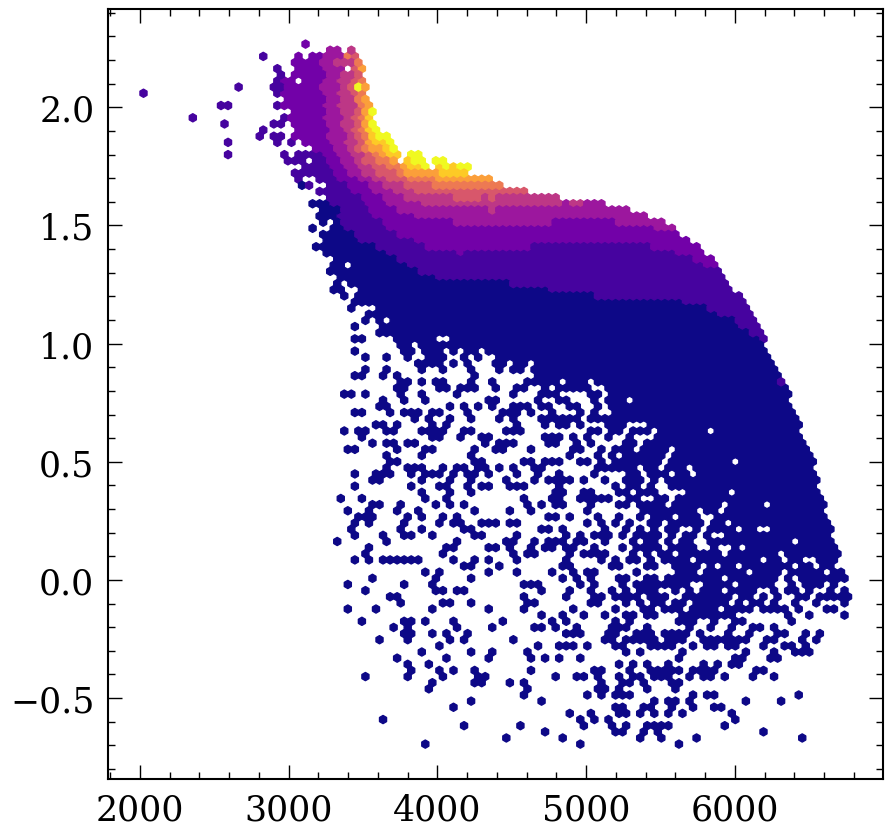

In [47]:
plt.hexbin(mh['teff_calc'], mh['Prot_log'], C=mh['gyroage'],
          cmap=plt.get_cmap('plasma', 10))


In [51]:
m = (mh['teff_calc']>3500)
plt.hexbin(mh['gyroage'][m], mh['mh_xgboost'][m], 
          mincnt=1, bins='log',cmap='binary',
          extent=(0,15,-1,0.5))

plt.hexbin(mh['gyroage'][~m], mh['mh_xgboost'][~m], 
           C=mh['teff_calc'][~m],
          mincnt=1, 
          extent=(0,15,-1,0.5))
plt.xlabel('Age')
plt.ylabel('FEH')
plt.colorbar()
# should be moving fast
# look at spectra
# souto paper abundance
# Find the brightest one
# 

Text(0, 0.5, 'FEH')

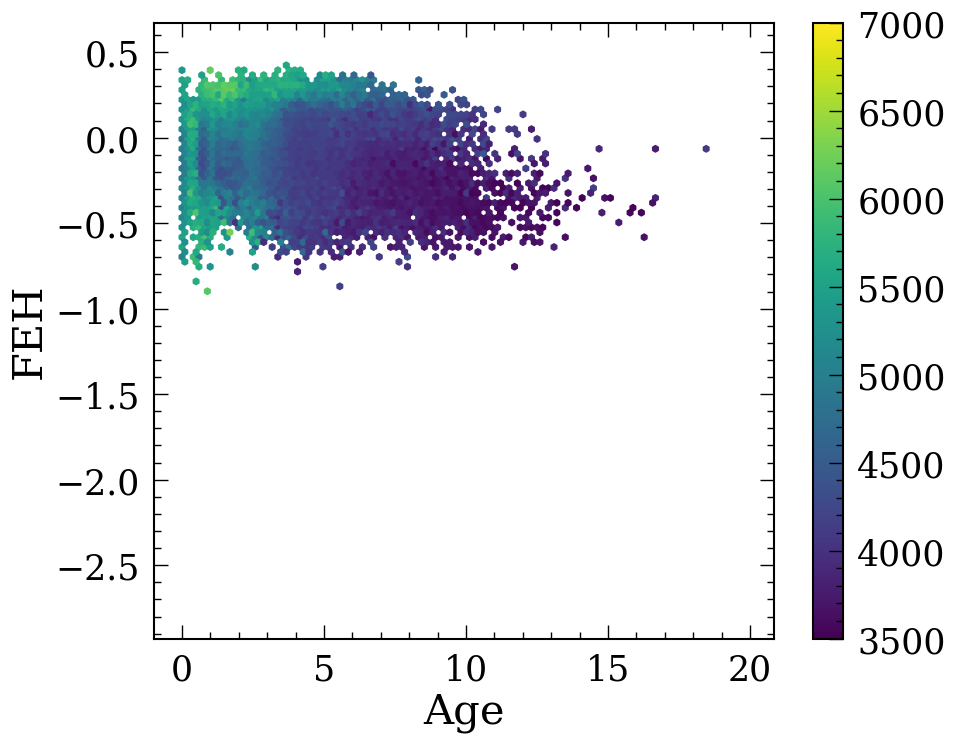

In [52]:
plt.figure(figsize=(10,8))
m = (mh['teff_calc']>3500)
plt.hexbin(mh['gyroage'][m], mh['mh_xgboost'][m], 
           C=mh['teff_calc'][m],
          mincnt=1,vmin=3500, vmax=7000)
plt.colorbar()
plt.xlabel('Age')
plt.ylabel('FEH')